In [1]:
## Se cargan las librerias necesarias para porder ejecutar las próximas celdas
import numpy as np

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from qibo import callbacks, gates, hamiltonians, models
from qibo.models import Circuit
from qibo.symbols import X, Y, Z, I

import seaborn as sns

from qibo import set_backend
#Uso de backend de numpy en Qibo
set_backend("numpy")

[Qibo 0.1.12.dev0|INFO|2024-05-22 12:50:11]: Using numpy backend on /CPU:0


In [2]:
# Generamos el dataset mediante la función "load_iris".
# Almacenamos los datos de entrada (inputs) en X y la etiqueta (label) correspondiente en y.
X, y = load_iris(return_X_y=True)

# Seleccionamos unicamente los inputs y labels de las dos primeras clases,
# esto corresponde a seleccionar las primeras 100 instancias
X = X[:100]
y = y[:100]

# Estandarizar los valores de los datos de entrada es importante
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Cambiamos los valores de las etiquetas a -1, 1. Se trata de un proceso importante para el clasificador SVM
# y la definición de la función de coste.
y_scaled = 2 * (y - 0.5)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, random_state=123)

In [3]:
def kernel_matrix(kernel,A, B, nqubits):

    return np.array([[kernel(a, b, nqubits) for b in B] for a in A])

In [4]:
# Definimos el número de qubits necesarios
nqubits=5

def circ_kernel_swap(x1, x2, nqubits):
    # Inicializamos el circuito con "nqubits"
    c= Circuit(nqubits=nqubits)
    
    # Generamos el Feature map mediante puertas RY
    c.add(gates.RY(q=1, theta=x1[0]))
    c.add(gates.RY(q=2, theta=x1[1]))
    c.add(gates.RY(q=3, theta=x2[0]))
    c.add(gates.RY(q=4, theta=x2[1]))
    
    # Kernel swap    
    c.add(gates.H(q=0))
    c.add(gates.SWAP(1,3).controlled_by(0))
    c.add(gates.SWAP(2,4).controlled_by(0))
    c.add(gates.H(q=0))
    
    # Añadimos la medida en el qubit 0
    c.add(gates.M(0))
    
    return c


# Definimos el observable necesario para calcular el valor esperado
def hamiltonian():
    Obj = np.prod([ Z(0), I(1), I(2), I(3), I(4)])
    h = hamiltonians.SymbolicHamiltonian(Obj)
    return h

# Calculamos el valor esperado que produce el circuito
def expVal_swap_test(x1, x2, nqubits, nshots=10000):
    c = circ_kernel_swap(x1, x2, nqubits)
    h = hamiltonian()
    expected_value = h.expectation(c.execute().state())
    
    return expected_value


In [5]:
# Se comprueba que el funcionamiento es adecuado.
expVal_swap_test(X_train[0], X_train[0], nqubits) 

0.9999999999999997

In [6]:
# Calculamos la matriz kernel al completo
matriz_swap = kernel_matrix(expVal_swap_test, X_train, X_train, nqubits)

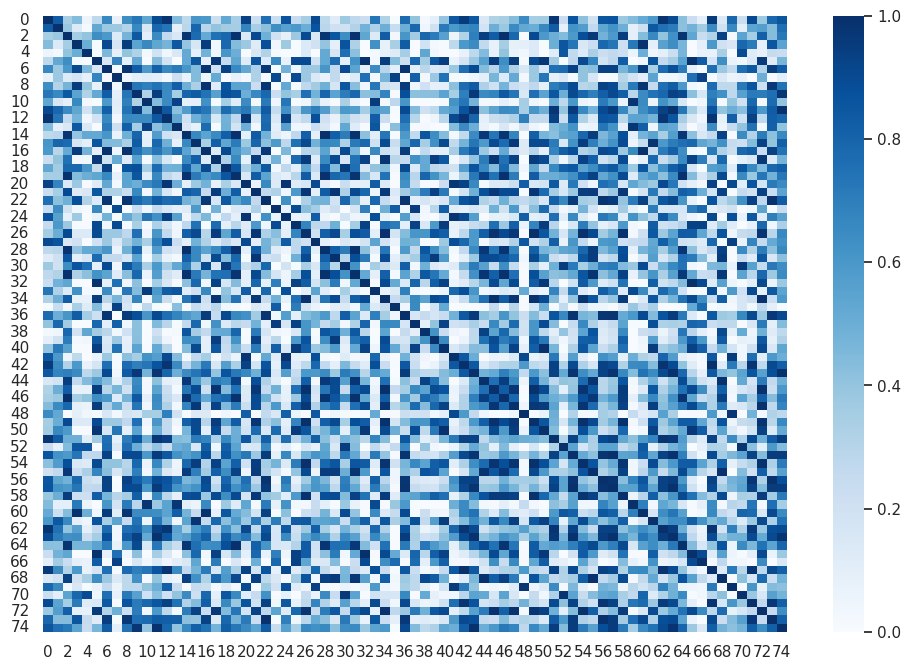

In [7]:
# Mostrar la matriz kernel mediante un mapa de calor.

sns.set(rc = {'figure.figsize':(12,8)})
sns.heatmap(matriz_swap, vmin = 0, vmax = 1, cmap=sns.color_palette("Blues", as_cmap=True));

In [8]:
n_qubits = len(X_train[0])
print("Número de qubits:", n_qubits)

Número de qubits: 4


In [9]:
nqubits = len(X_train[0]) 

def circ_kernel_QKE(x, y, nqubits):
    
    # cuatro cúbits: cuatro características
    n_shots = 8000

    # Inicializar el circuito, generar un circuito vacio
    circuit = Circuit(n_qubits)

    # Codificación cuántica en puertas RY y medir todos los qubits
    for pos in range(n_qubits):
        circuit.add(gates.RY(pos, y[pos]))
        circuit.add(gates.RY(pos, x[pos]).dagger())
        circuit.add(gates.M(pos))
    
    return circuit


# Definir el observable
def hamiltonian():
    Obj = np.prod([ Z(0), I(1), I(2), I(3)])
    h = hamiltonians.SymbolicHamiltonian(Obj)
    return h

# Ejecutar el circuito y calcular el valor esperado
def expVal_swap_QKE(x1, x2, nqubits, nshots=10000):
    c = circ_kernel_QKE(x1, x2, nqubits)
    h = hamiltonian()
    expected_value = h.expectation(c.execute().state())
    
    return expected_value


In [10]:
# Se comprueba que el funcionamiento es adecuado.
expVal_swap_QKE(X_train[0], X_train[0],nqubits)

0.9999999999999996

In [11]:
# Calculamos la matriz kernel al completo
matriz_proyector = kernel_matrix(expVal_swap_QKE, X_train, X_train, nqubits)

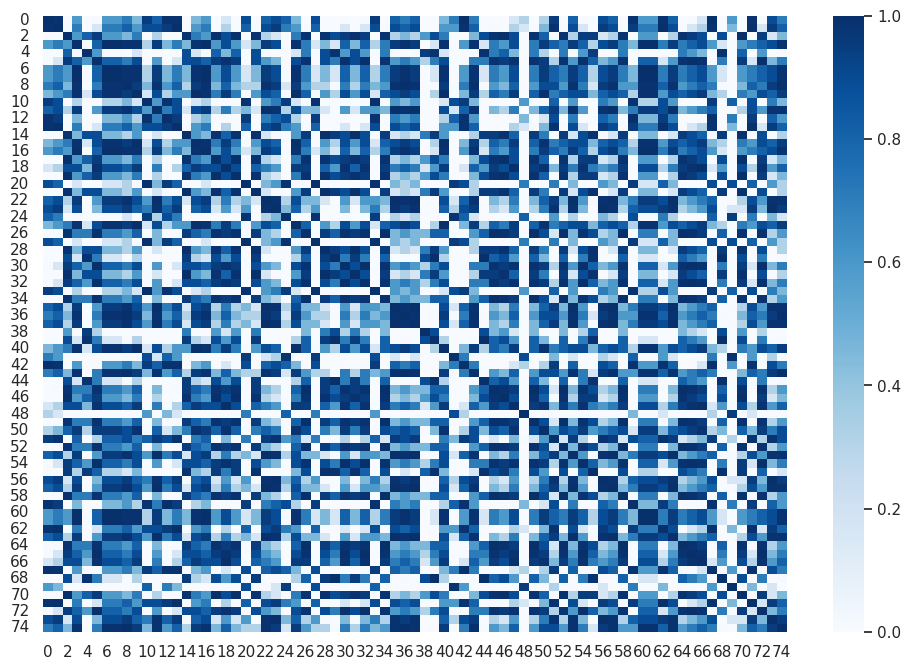

In [12]:
sns.set(rc = {'figure.figsize':(12,8)})
sns.heatmap(matriz_proyector, vmin = 0, vmax = 1, cmap=sns.color_palette("Blues", as_cmap=True));

In [13]:
# kernel cuántico
def distancia_circuit(x,y,n_qubits):
    
    # cuatro cúbits: cuatro características
    n_shots = 8000

    # Create an empty circuit
    circuit = Circuit(n_qubits)

    # Codificación cuántica en puertas RY 
    for pos in range(n_qubits):
        circuit.add(gates.RY(pos, y[pos]))
        circuit.add(gates.RY(pos, x[pos]).dagger())
        circuit.add(gates.M(pos))

    # ejecución del circuito n veces (n_shots)
    result = circuit.execute(nshots=n_shots)

    # Devuelve las probabilidades analíticas
    return result.probabilities()
       
# Se devuelve el probabilidad del base computacional "0000"
kernel = lambda x1, x2, n_qubits: distancia_circuit(x1, x2, n_qubits)[0]

In [14]:
#Se comprueba que el funcionamiento es adecuado.
kernel(X_train[0], X_train[0], nqubits) 

0.9999999999999996

In [15]:
# Calculamos la matriz kernel al completo
matriz_prob = kernel_matrix(kernel,X_train,X_train,n_qubits)

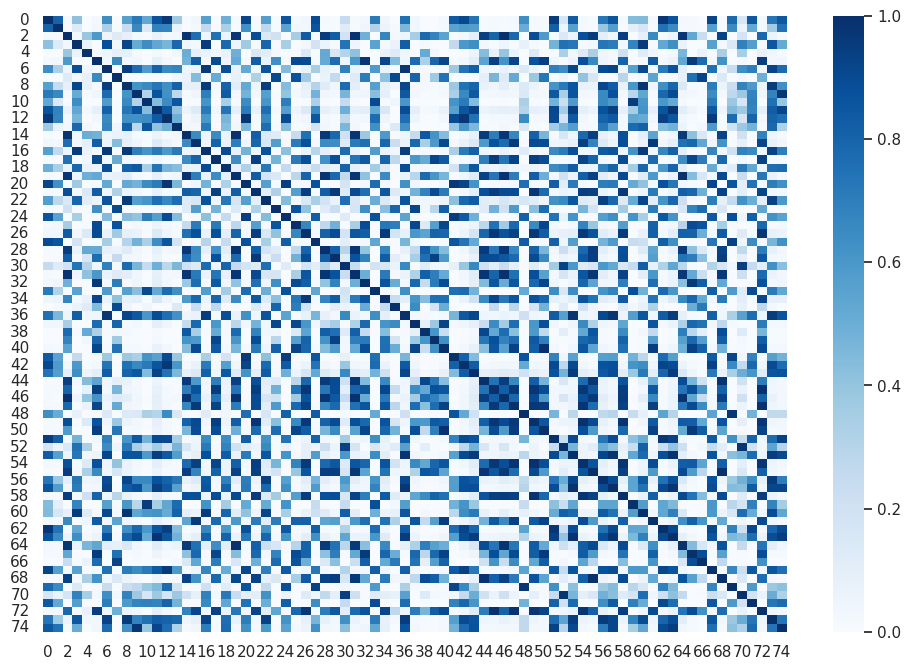

In [16]:
sns.set(rc = {'figure.figsize':(12,8)})
sns.heatmap(matriz_prob, vmin = 0, vmax = 1, cmap=sns.color_palette("Blues", as_cmap=True));